In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(set(''.join(words)))
s_to_i = {s:i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s = {i:s for s,i in s_to_i.items()}
vocab_size = len(i_to_s)
print(i_to_s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = s_to_i[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### MLP revisited

In [12]:
n_emb = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # no. of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647) # for reproducibility
# the multiplier is calculated via Kaiming init
C = torch.randn(vocab_size, n_emb, 				generator=g) * (5/3)/(n_emb * block_size)**0.5
W1 = torch.randn(block_size * n_emb, n_hidden, 	generator=g) * 0.2
b1 = torch.randn(n_hidden,						generator=g) * 0.01
# multiplying by 0.01 in order to have a good initial loss
# good initial loss can be calculated because it's the NLL of 1/27 = 3.2958
W2 = torch.randn(n_hidden, vocab_size, 			generator=g) * 0.01
b2 = torch.randn(vocab_size, 					generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
	p.requires_grad = True

11897


In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

	# minibatch construction
	ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

	# forward pass
	emb = C[Xb] # embed characters into vectors
	embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
	hpreact = embcat @ W1 + b1 # hidden layer pre-activation
	h = torch.tanh(hpreact) # hidden layer
	logits = h @ W2 + b2 # output layer
	loss = F.cross_entropy(logits, Yb) # loss function

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())



      0/ 200000: 3.3031
  10000/ 200000: 2.1448
  20000/ 200000: 2.3168
  30000/ 200000: 2.3945
  40000/ 200000: 1.9721
  50000/ 200000: 2.4471
  60000/ 200000: 2.3960
  70000/ 200000: 2.0547
  80000/ 200000: 2.3534
  90000/ 200000: 2.0976
 100000/ 200000: 1.7685
 110000/ 200000: 2.1997
 120000/ 200000: 1.8678
 130000/ 200000: 2.4473
 140000/ 200000: 2.2826
 150000/ 200000: 2.1977
 160000/ 200000: 1.8869
 170000/ 200000: 1.7446
 180000/ 200000: 1.8655
 190000/ 200000: 1.8877


### Kaiming Initialization
- Derivative of `tanh` = `1 - tanh**2`
- Its always in the range of `[0, 1]`, essentially making it an "attenuation" function because of the chain rule: `gradient_to_layer_below = gradient_from_above × local_derivative` (for tanh, it's always less than 1)
- If we have a lot of values near to 1/-1, that essentially means that we are "killing" the gradient
- The plot below shows that we have this issue  
<br>![](./images/tanh-preact.png)
- We also plot the values of the hidden layer to have a better visual representation of how many values are like this. We see that while most of it is white (which is not good), we do not have _entire_ columns of white which would mean that there is a "dead" neuron: that is, that neuron will never train  
<br>![](./images/h-values.png)
- We mitigate this by reducing the values of the `W1` and `b1` by multiplying them with something like `0.2` and `0.01` respectively and regenerate the graphs. We see that the graphs are much better  
<br>![](./images/tanh-preact-2.png)
![](./images/h-values-2.png)
- We got the values `0.2` and `0.01` by using fairly unscientific methods; we would like to get to these numbers in a more principled manner. We use the concept of Kaiming initialization for that (Paper: [Kaiming et al](https://arxiv.org/abs/1502.01852))
- PyTorch has [inbuilt Kaiming initialization](https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_), we make use of that documentation to get the value which we multiply with for initializing W1 with a calculated constant instead of just `0.2`

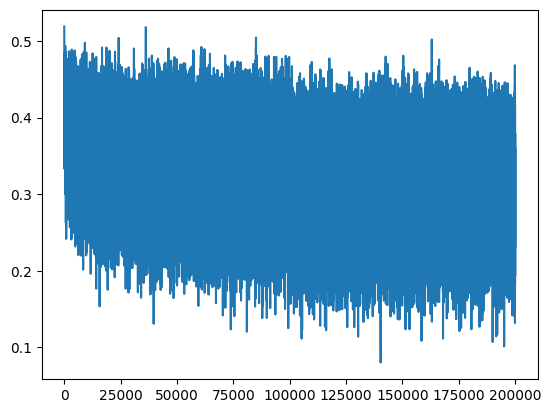

In [14]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.2803754806518555
val 3.2805075645446777


### BatchNorm: Batch normalization
- Paper: https://arxiv.org/pdf/1502.03167
- We would like the preactivation weights (`hpreact`), at least at initialization, to be roughly gaussian (std dev = 1) because too extreme values would either destroy the gradiend or make `tanh` act as a pass-through
- Batch normalization solves that by just literally taking these weights of the hidden layer and just normalize them
- This works because the process of normalization is a bunch of mathematical expressions which are completely differentiable
- `hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True))`
- To make the neural network to "learn" and manipulate the weights so that the hidden layer's is not forced to be normalized in every step, we multiply it by a certain gain and add a certain bias
  
  `bngain = torch.ones((1, n_hidden))`
  
  `bnbias = torch.zeros((1, n_hidden))`
  
  These will be included in the parameters list so that they can be trained
  
  <img src="./images/batch-norm.png" alt="batch-norm" width="400"/>

  *The "+ $\epsilon$" in the normalization equation is a very small constant (usually 1e-5) added to the denominator so that in cases where the standard deviation is zero, it does not result in a divide by zero error; we have a small MLP, so we will most probably not run into that and are avoiding it

**Side effect of batch normalization**
- During the forward pass and backward pass, the mean and std is calculated with the values of the _entire_ batch, wherein the values are sampled randomly
- So doing the forward pass for a single random sample as well introduces "noise"/"jitter"/"padding" to that tensor
- This added, unwanted "noise" is actually helpful because it adds certain entropy and acts as a regulizer and mitigates to an extent, the overfitting of the system

**Sampling from batch normalization**
- Since the mean and std are calculated wrt the entire batch, the neural network expects a batch as an input too, instead of a single example
- Solution to this is that once the NN is trained, we calculate the mean and std of the entire batch (`Xtr`) and then use this during inference
- People be lazy, so instead of doing this as an additional step, we can just have a running mean and std while training and use them once the training is completed
- While calculating the running mean, care has to be taken in considering the `momentum` (a parameter used in the `BatchNorm1d` class in PyTorch), in our case it is `0.001` (from bnmean_running = 0.999 * bnmean_running + `0.001` * bnmeani). For smaller batch sizes, larger momentums can be dangerous because statistically, the mean and the std _may not_ converge to the entire batch's mean and std because it will thrash around quite a bit owing to the smaller batch size

**Why `b1` is useless**
```python
hpreact - mean(hpreact) 
= (embcat @ W1 + b1) - mean(embcat @ W1 + b1)
= (embcat @ W1 + b1) - (mean(embcat @ W1) + b1)
= embcat @ W1 - mean(embcat @ W1)
```
b1 appears in both terms and cancels out. This is because:

mean(embcat @ W1 + b1)  
= mean(embcat @ W1) + mean(b1)  
= mean(embcat @ W1) + b1

**The mean of a constant (b1) is just that constant itself**

In [10]:
n_emb = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # no. of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647) # for reproducibility
# the multiplier is calculated via Kaiming init
C = torch.randn(vocab_size, n_emb, 				generator=g) * (5/3)/(n_emb * block_size)**0.5
W1 = torch.randn(block_size * n_emb, n_hidden, 	generator=g) * 0.2
#b1 = torch.randn(n_hidden,						generator=g) * 0.01
# multiplying by 0.01 in order to have a good initial loss
# good initial loss can be calculated because it's the NLL of 1/27 = 3.2958
W2 = torch.randn(n_hidden, vocab_size, 			generator=g) * 0.01
b2 = torch.randn(vocab_size, 					generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# initalized with zeros because initially, gaussian distribution ensures that the mean is close to zero
bnmean_running = torch.zeros((1, n_hidden))
# initalized with ones because initially, gaussian distribution ensures that the std is close to one
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
	p.requires_grad = True

12297


In [11]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

	# minibatch construction
	ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

	# forward pass
	emb = C[Xb] # embed characters into vectors
	embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
	hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

	bnmeani = hpreact.mean(0, keepdim=True)
	bnstdi = hpreact.std(0, keepdim=True)

	hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
	h = torch.tanh(hpreact) # hidden layer
	logits = h @ W2 + b2 # output layer
	loss = F.cross_entropy(logits, Yb) # loss function

	with torch.no_grad():
		bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
		bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())



TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
	x,y = {
	'train': (Xtr, Ytr),
	'val': (Xdev, Ydev),
	'test': (Xte, Yte),
	}[split]
	emb = C[x] # (N, block_size, n_embd)
	embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
	hpreact = embcat @ W1 + b1
	hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
	h = torch.tanh(hpreact) # (N, n_hidden)
	logits = h @ W2 + b2 # (N, vocab_size)
	loss = F.cross_entropy(logits, y)
	print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0614492893218994
val 2.106208086013794
